# Lab 3 Schokley Ramo Theorem Code setup
Kalie Knecht
heavily inspired by https://github.com/lbl-anp/GammaRayTrackingSchool_2018/

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
# from spectrum import gaussian
import pandas as pd

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
# sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab2')
# from tools import find_activity, import_data, subtract_baseline
# from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
# from spectrum import spectrum, gaussian
# from pulse_shape import find_rise_time

In [3]:
# set detector params

# Detector is a 1 x 1 x 1 cm3 CdZnTe crystal from Redlen Technologies 
# Cathode: full area; Anode: 3 x 3 pixel array surrounded by a guard ring; 
# Pixels: 0.75 x 0.75 mm2 on 1 mm pitch 

detector_width = 10.0 # mm
detector_height = 10.0 # mm
pixel_size_mm = 1 # mm

cathode_contact_bias = -1000.0
anode_contact_bias = 0.0

charge_density_zero = -1.0 #TODO - change
charge_density_gradient = 0.1 #TODO - change

In [4]:
# build (uniform) 2D grids for plotting and solving (x=width, y=height (cathode to anode))
x_range = np.arange(0, detector_width, pixel_size_mm)
y_range = np.arange(0, detector_height, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)

# XY mesh for plotting later
X, Y = np.meshgrid(y_range, x_range)

In [5]:
# build a little map of geometry for later, designating pixels based on their nature
# 0 = CZT
# 1 = cathode face
# 2 = anode face
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# outer contact
geom_map[0,:] = 2 # anodes
geom_map[-1,:] = 1 # cathode
geom_map

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [6]:
# set up charge distribution through xtal
charge = np.zeros((N_xelements, N_yelements), dtype=float)
pixels_to_cm = 10/pixel_size_mm

for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        charge[x,y] = charge_density_zero + charge_density_gradient*(y/pixels_to_cm)

#         # core
#         if (x_range[x]<core_radius_mm and y_range[y]<core_length_mm):
#             charge[x,y] = 0.0
#             geom_map[x,y] = 2

charge

array([[-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91],
       [-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91]])

<IPython.core.display.Javascript object>


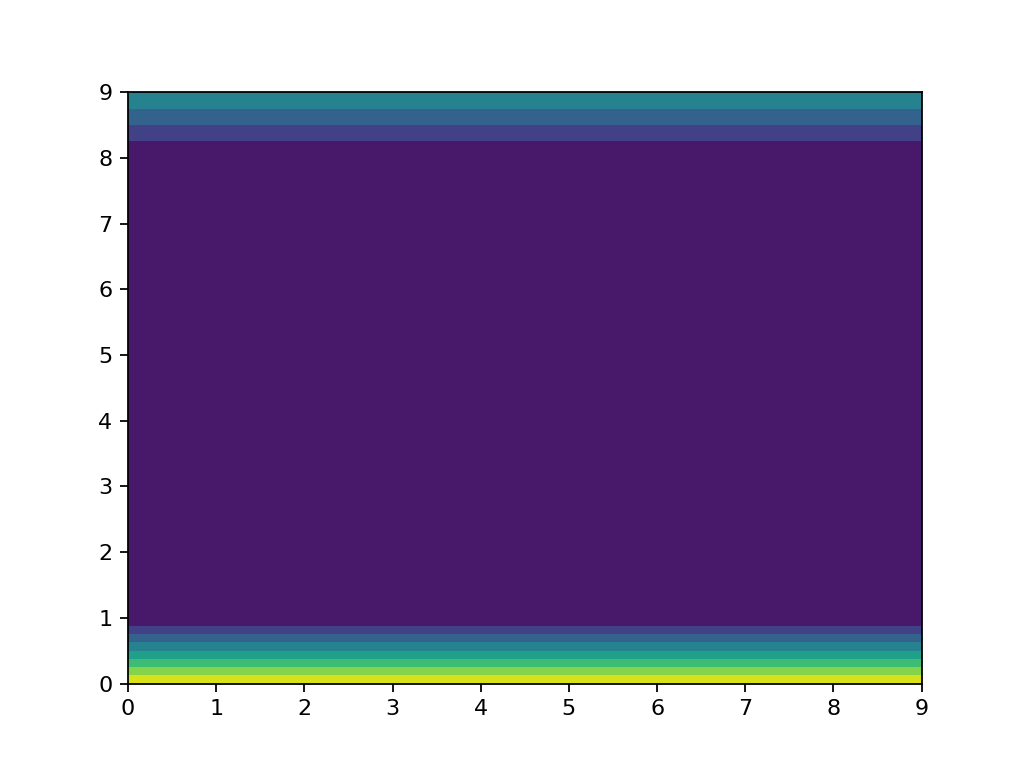

In [7]:
# view the geometry (x/y are flipped)
plt.figure()
plt.contourf(geom_map)
# ax = plt.axes()
# plt.minorticks_on()
# plt.grid("on")
# plt.xlabel('Pixel #')
# plt.ylabel('Pixel #')
plt.show()

In [8]:
# set boundary conditions and generate initial guess at solution
# 1 = cathode, 0 = core, 2 = anode
V = np.zeros((N_xelements, N_yelements), dtype=float)

# initial guess at solution
for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        V[x,y] = cathode_contact_bias*x / N_xelements

# cathode
x,y = np.where(geom_map==1)
V[x,y] = cathode_contact_bias

# anode
x,y = np.where(geom_map==2)
V[x,y] = anode_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

In [9]:
V

array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.],
       [ -100.,  -100.,  -100.,  -100.,  -100.,  -100.,  -100.,  -100.,
         -100.,  -100.],
       [ -200.,  -200.,  -200.,  -200.,  -200.,  -200.,  -200.,  -200.,
         -200.,  -200.],
       [ -300.,  -300.,  -300.,  -300.,  -300.,  -300.,  -300.,  -300.,
         -300.,  -300.],
       [ -400.,  -400.,  -400.,  -400.,  -400.,  -400.,  -400.,  -400.,
         -400.,  -400.],
       [ -500.,  -500.,  -500.,  -500.,  -500.,  -500.,  -500.,  -500.,
         -500.,  -500.],
       [ -600.,  -600.,  -600.,  -600.,  -600.,  -600.,  -600.,  -600.,
         -600.,  -600.],
       [ -700.,  -700.,  -700.,  -700.,  -700.,  -700.,  -700.,  -700.,
         -700.,  -700.],
       [ -800.,  -800.,  -800.,  -800.,  -800.,  -800.,  -800.,  -800.,
         -800.,  -800.],
       [-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000., -1000.]])

<IPython.core.display.Javascript object>


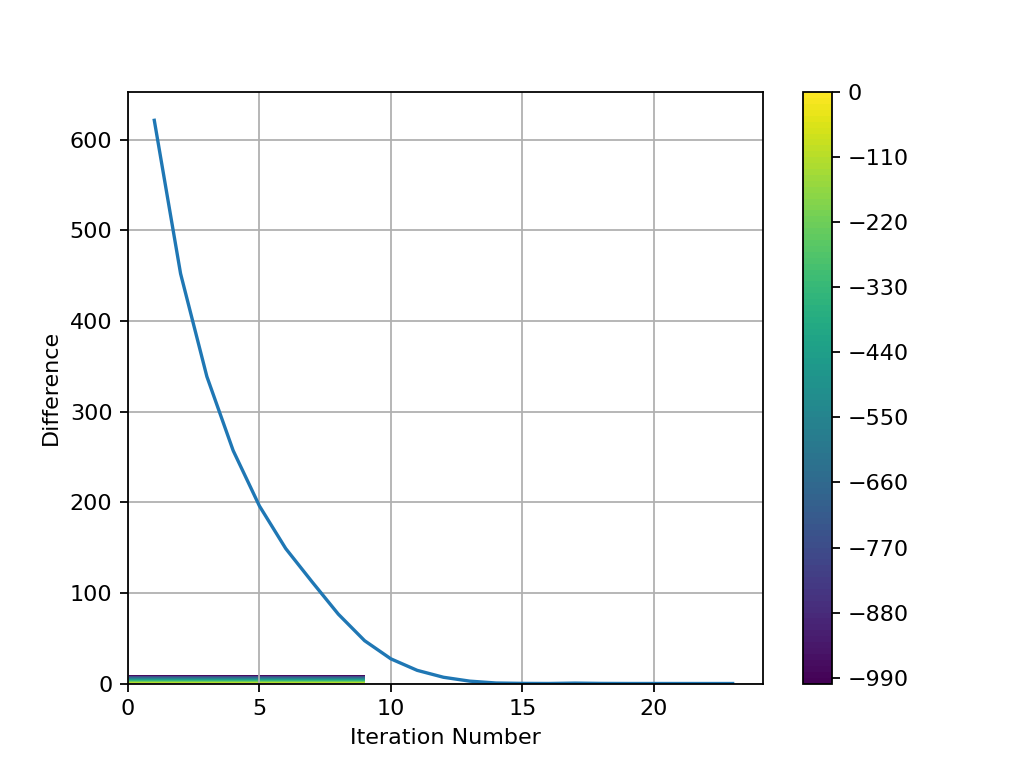

/var/folders/9q/zxs3bttx79j7gy8t3m35pzm40000gn/T/ipykernel_53085/2715891477.py:2: UserWarning: The following kwargs were not used by contour: 'interpolation'
  plt.contourf(V,100,interpolation="None")


In [10]:
plt.figure()
plt.contourf(V,100,interpolation="None")
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.show()

In [27]:
# do the relaxation to solve

# set maximum number of iterations
max_iters = 100

# calculate term for Coulombs per pixel / Epsilon
#e_over_e = (pixel_size_mm*pixel_size_mm) * 1e10 * 1.6e-19
e_over_e = (pixel_size_mm*pixel_size_mm/4)* (1e10*1.6e-19)/(16*8.85e-12)

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(0, N_yelements):
        for x in range(0, N_xelements):
                        
            # skip non-Ge pixels
            if (geom_map[x,y] != 0):
                continue
            
            # handle edges
                                     
#             V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            V_local_sum = (V[x+1,y] + V[x-1,y] )
            
            # update the solution
            R[x,y] = (0.25*V_local_sum + (charge[x,y] * e_over_e)) - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
                 
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

In [25]:
geom_map

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

<IPython.core.display.Javascript object>


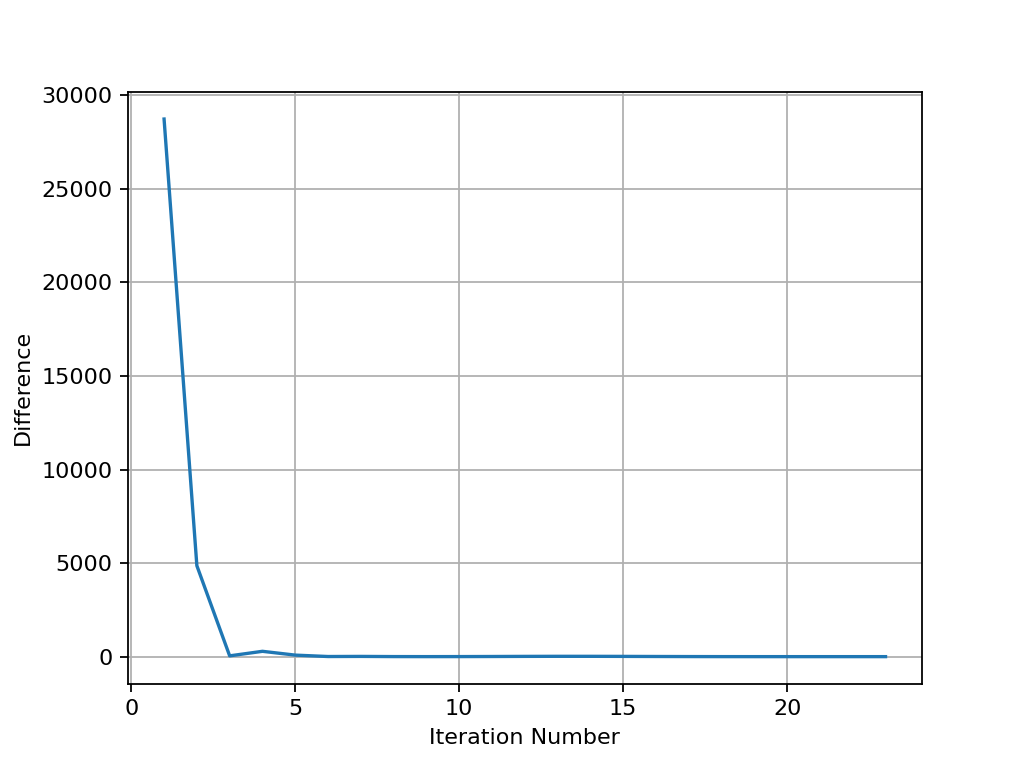

Final Difference:
0.0017355435594299529


In [28]:
# plot difference vs iteration number
plt.figure()
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
#plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

<IPython.core.display.Javascript object>


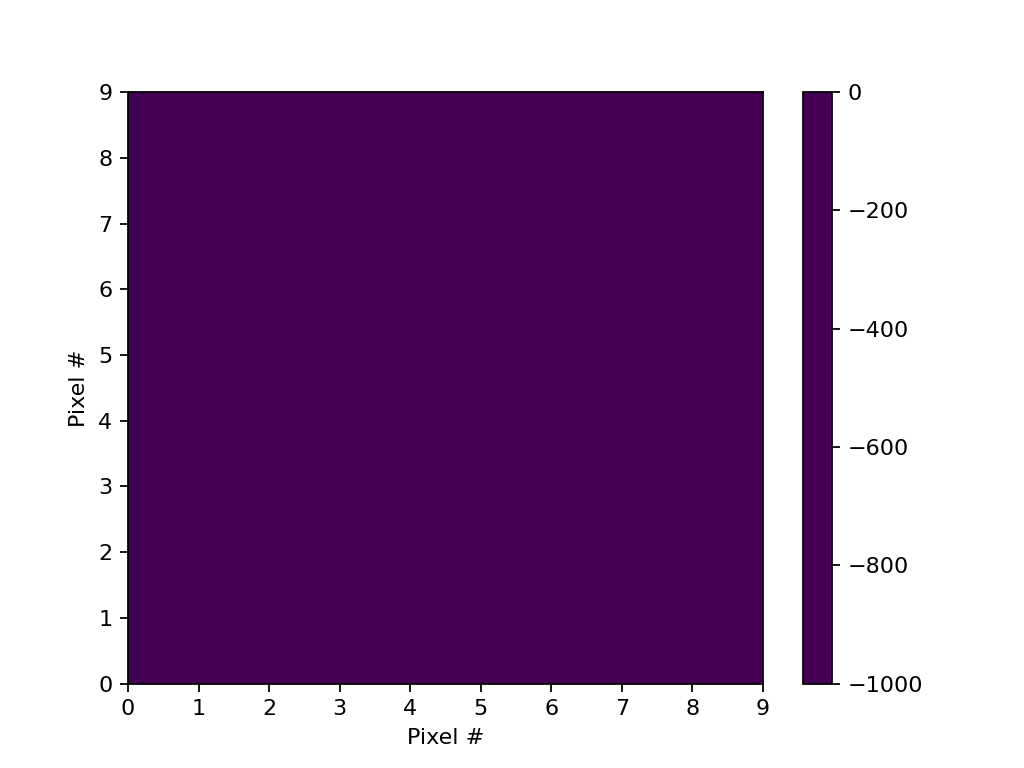

In [32]:
plt.figure()
plt.contourf(V, 10, vmin=0)
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.show()

In [34]:
V

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       [   -4.16070422,    -4.11936187,    -4.07801528,    -4.036664  ,
           -3.99530845,    -3.95394886,    -3.91258509,    -3.87121681,
           -3.82984457,    -3.78847475],
       [   -5.34270112,    -5.29028705,    -5.2378631 ,    -5.18543333,
           -5.13299963,    -5.08056255,    -5.02812158,    -4.97567492,
           -4.92321858,    -4.87074448],
       [   -5.90902899,    -5.85364204,    -5.79825193,    -5.74286145,
           -5.68747166,    -5.6320828 ,    -5.57669459,    -5.52130595,
           -5.46591403,    -5.41051287],
       [   -6.99403225,    -6.93790532,    -6.88177485,    -6.82564485,
           -6.76951624,    -6.71338916,    -6.65726343,    -6.60113809,
           -6.5450091 ,    -6.48886006],
       [  -10.76715866,   -10.71101193,   -10.65487345,   -10.59874014,
   

<IPython.core.display.Javascript object>


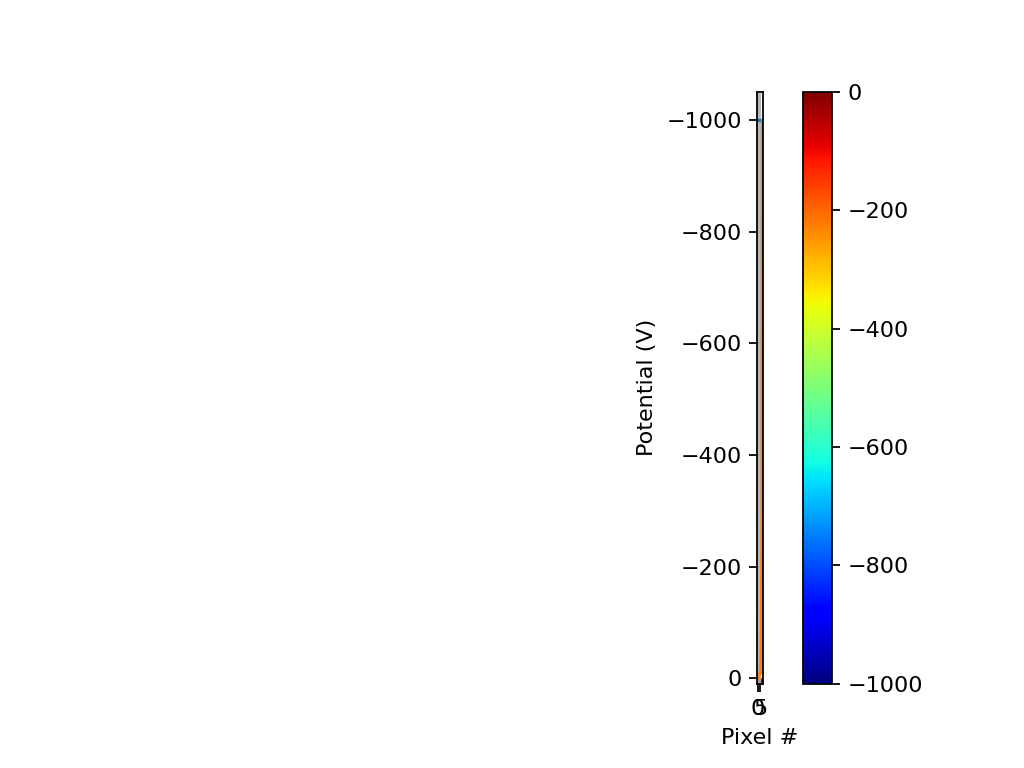

In [38]:
plt.figure()
plt.imshow(V,interpolation='None',cmap='jet')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


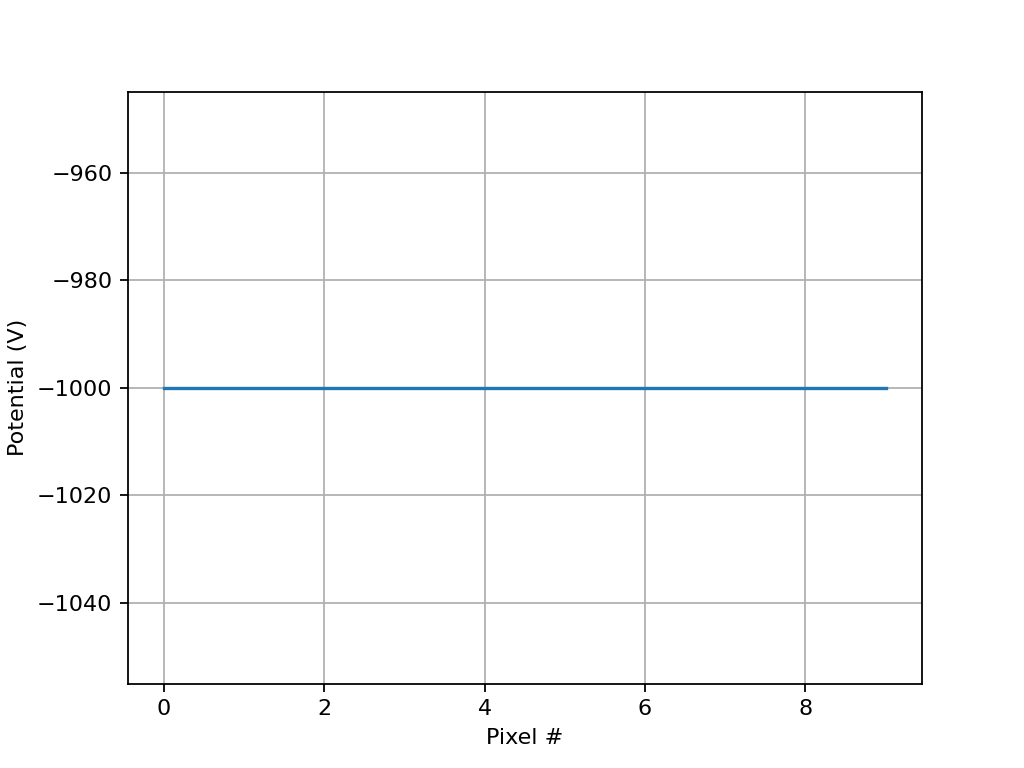

<IPython.core.display.Javascript object>


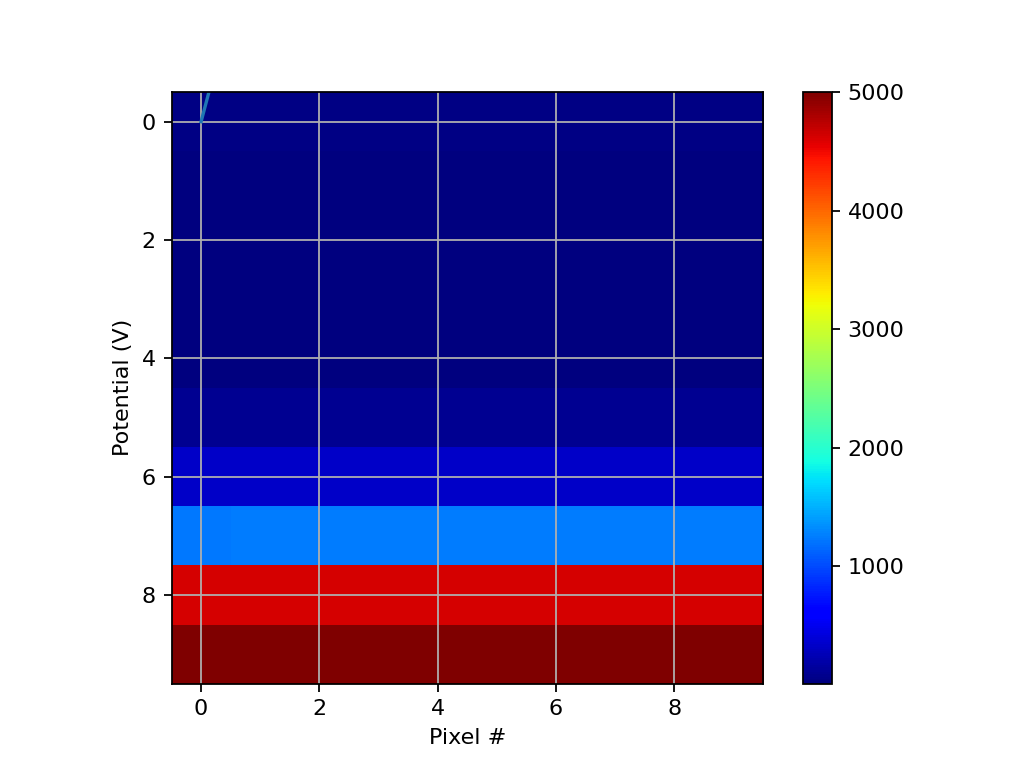

In [43]:
# plot some potential/field slices
yy = 9
xx = 9

# V along the longitudinal direction at rad = yy
plt.figure()
plt.plot(V[yy,:])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

# V along the radial direction at long = xx
plt.figure()
plt.plot(V[:,yy])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

In [44]:
#  calculate the electric field from the potential
#  - this doesn't deal with boundaries properly!
[Ex, Ey] = np.gradient(-V)
Ex = Ex * pixels_to_cm
Ey = Ey * pixels_to_cm
E = np.sqrt((Ex*Ex) + (Ey*Ey))

In [ ]:
Efinal = np.flipud(E)
Efinal = np.append(Efinal, E, axis=0)

<IPython.core.display.Javascript object>


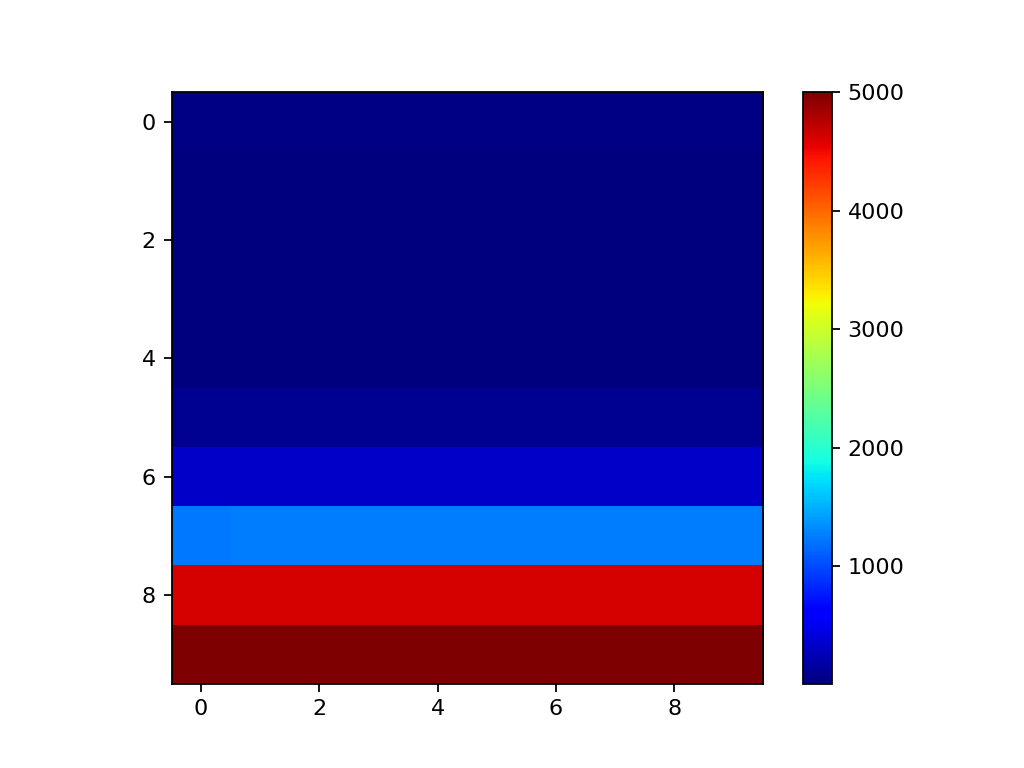

In [47]:
plt.figure()
plt.imshow(E, vmax=5000, interpolation="None", cmap="jet")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


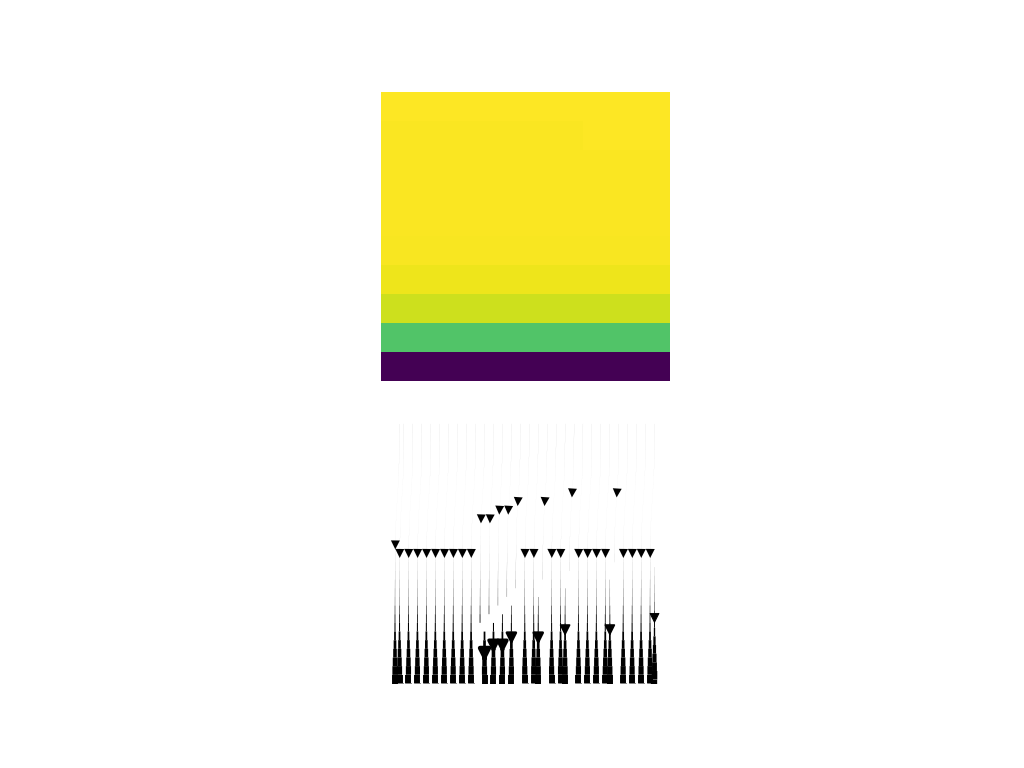

In [52]:
# plot the potential and overlay field lines
plt.figure()
lw = 3 * E/E.max()
plt.imshow(V)
plt.streamplot(X, detector_width+pixel_size_mm+Y, Ey, Ex, color='k', linewidth=lw)
plt.axis("off")
plt.show()